Name: David Andres Quiroga

# Encoding and Classifier
The task at hand consists of encoding train and test datasets onto a quantum circuit in at least two different ways and designing an ansatz to use as a variational quantum circuit in order to classify the encoded data correctly. Here I use both the RawFeatureVector encoding map for amplitude encoding and the ZFeatureMap for kernel encoding, and find the best ansatz for the problem.

I import all the necessary libraries, configure the quantum instance the training will occur on, and prepare the input data to be encoded.

In [59]:
import numpy as np
import pandas as pd

from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, PauliFeatureMap, ZFeatureMap
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
# set method to calculcate expected values
expval = AerPauliExpectation()

# define gradient method
gradient = Gradient()

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

# we set shots to 500 as this will determine the number of samples later on.
qi_qasm = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)

num_qubits = 2

In [9]:
data_train = pd.read_csv('mock_train_set.csv')
data_train

,0,1,2,3,4
0,2789.26,1000.0,10.0,20.0,0.0
1,4040.01,1000000.0,1.0,1.0,1.0
2,2931.20,10000.0,10000.0,40.0,1.0
3,3896.54,10000.0,100000.0,30.0,1.0
4,982.06,100.0,1000.0,75.0,0.0
...,...,...,...,...,...
295,1464.52,1000000.0,10000.0,45.0,1.0
296,3493.66,1000000.0,100000.0,85.0,1.0
297,4182.81,1.0,1.0,65.0,0.0
298,3113.75,10000.0,100.0,1.0,1.0


In [10]:
X_train = data_train[['0','1','2','3']].to_numpy()
y_train = data_train[['4']].to_numpy()
X_train

array([[2.78926e+03, 1.00000e+03, 1.00000e+01, 2.00000e+01],
       [4.04001e+03, 1.00000e+06, 1.00000e+00, 1.00000e+00],
       [2.93120e+03, 1.00000e+04, 1.00000e+04, 4.00000e+01],
       ...,
       [4.18281e+03, 1.00000e+00, 1.00000e+00, 6.50000e+01],
       [3.11375e+03, 1.00000e+04, 1.00000e+02, 1.00000e+00],
       [4.56757e+03, 1.00000e+04, 1.00000e+05, 9.00000e+01]])

In [11]:
y_train

array([[0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],

In [12]:
data_test = pd.read_csv('mock_test_set.csv')
data_test

,0,1,2,3,4
0,2988.55,10000.0,10000.0,75.0,1.0
1,3413.80,1.0,100.0,90.0,0.0
2,3891.52,1.0,1.0,5.0,0.0
3,4514.99,10000.0,1000000.0,25.0,1.0
4,752.29,10.0,10.0,90.0,0.0
...,...,...,...,...,...
115,3155.94,10000.0,10000.0,35.0,1.0
116,2795.04,1.0,10.0,45.0,0.0
117,3702.48,1.0,1.0,20.0,0.0
118,2790.57,1.0,1.0,40.0,0.0


In [13]:
X_test = data_test[['0','1','2','3']].to_numpy()
y_test = data_test[['4']].to_numpy()
X_test

array([[2.98855e+03, 1.00000e+04, 1.00000e+04, 7.50000e+01],
       [3.41380e+03, 1.00000e+00, 1.00000e+02, 9.00000e+01],
       [3.89152e+03, 1.00000e+00, 1.00000e+00, 5.00000e+00],
       [4.51499e+03, 1.00000e+04, 1.00000e+06, 2.50000e+01],
       [7.52290e+02, 1.00000e+01, 1.00000e+01, 9.00000e+01],
       [1.40413e+03, 1.00000e+04, 1.00000e+03, 5.00000e+00],
       [3.39065e+03, 1.00000e+06, 1.00000e+04, 5.00000e+00],
       [2.62098e+03, 1.00000e+00, 1.00000e+01, 7.50000e+01],
       [2.05960e+02, 1.00000e+01, 1.00000e+02, 1.50000e+01],
       [1.49575e+03, 1.00000e+04, 1.00000e+04, 8.00000e+01],
       [2.41590e+02, 1.00000e+04, 1.00000e+05, 1.00000e+01],
       [4.01638e+03, 1.00000e+06, 1.00000e+03, 4.50000e+01],
       [7.21820e+02, 1.00000e+00, 1.00000e+00, 3.50000e+01],
       [5.76980e+02, 1.00000e+00, 1.00000e+02, 4.00000e+01],
       [4.85430e+03, 1.00000e+03, 1.00000e+01, 7.00000e+01],
       [4.82122e+03, 1.00000e+03, 1.00000e+06, 8.50000e+01],
       [2.39061e+03, 1.0

In [14]:
y_test

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],

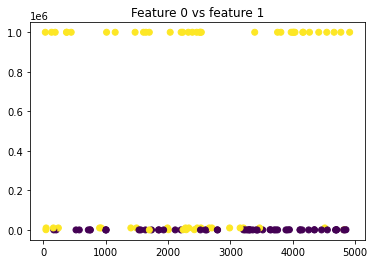

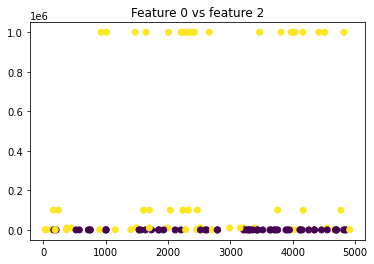

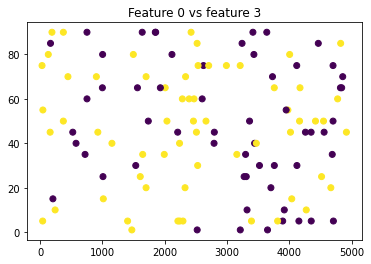

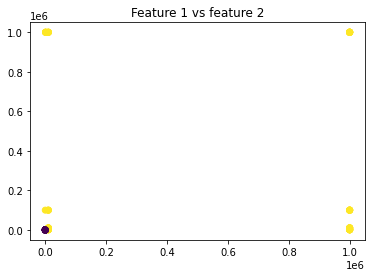

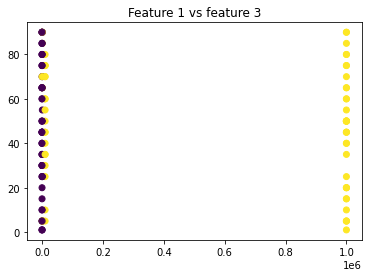

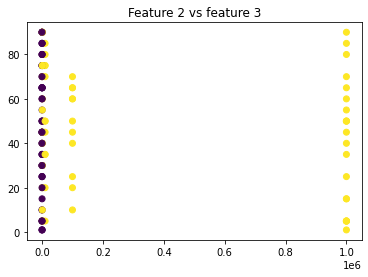

In [117]:
import itertools
pairs = list(itertools.combinations(list(range(X_test.shape[1])),2))
for pair in pairs:
    plt.scatter(X_test[:,pair[0]], X_test[:,pair[1]],c=y_test)
    plt.title(f'Feature {pair[0]} vs feature {pair[1]}')
    plt.show()

# Amplitude encoding
I use the RawFeatureVector mapping to do amplitude encoding of the input data using two repetitions of the RealAmplitudes ansatz.

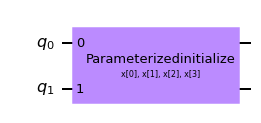

In [23]:
initial = RawFeatureVector(2**num_qubits)
initial.draw(output='mpl')

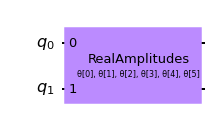

In [4]:
ansatz = RealAmplitudes(num_qubits, entanglement='full', reps=2)
ansatz.draw(output='mpl')

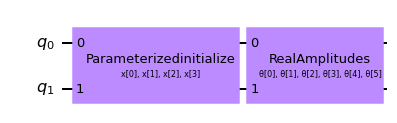

In [5]:
qc = QuantumCircuit(num_qubits)
qc.append(initial, range(num_qubits))
qc.append(ansatz, range(num_qubits))
qc.decompose().draw(output='mpl')

In [6]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2
output_shape = 2**(num_qubits-1)

In [7]:
# specify circuit QNN
qnn = CircuitQNN(qc, input_params=initial.parameters, weight_params=ansatz.parameters, output_shape=output_shape, interpret=parity, 
                  quantum_instance=qi_qasm)

Cannot compute gradient operator! Continuing without gradients!


In [8]:
initial.parameters, ansatz.parameters

(ParameterView([ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(x[2]), ParameterVectorElement(x[3])]),
 ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5])]))

In [15]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    print('Iteration is', len(objective_func_vals))
    print('Weights are', weights)
    print('Objective function value is', obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [16]:
circuit_classifier = NeuralNetworkClassifier(neural_network=qnn, callback=callback_graph,
                                             optimizer=COBYLA())

Iteration is 95
Weights are [1.68040214 0.61081444 0.44844014 0.38630419 1.28497172 2.59008352]
Objective function value is 56.0380859375


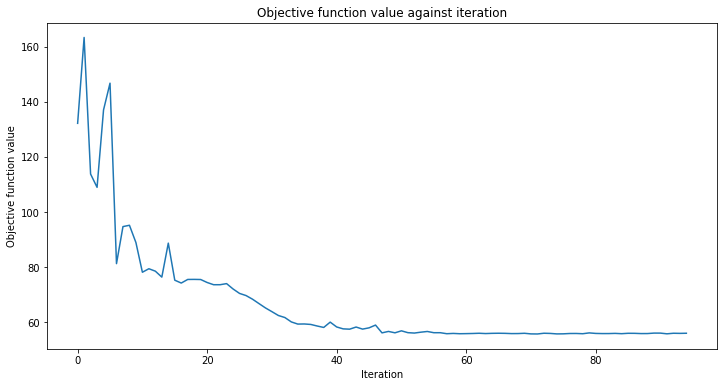

0.8233333333333334

In [17]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
circuit_classifier.fit(X_train, y_train.flatten())

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
circuit_classifier.score(X_train, y_train.flatten())

In [18]:
circuit_classifier.score(X_test, y_test.flatten())

1.0

In [19]:
circuit_classifier.predict(X_test)

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0], dtype=int64)

In [20]:
y_test.flatten()

array([1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0.])

# Kernel encoding
I use the ZFeatureMap to do kernel encoding of the input data using two repetitions of the RealAmplitudes ansatz.

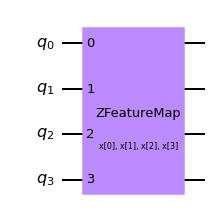

In [82]:
initial = ZFeatureMap(2**num_qubits)
initial.draw(output='mpl')

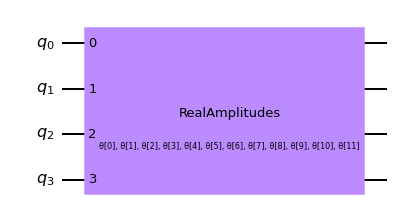

In [83]:
ansatz = RealAmplitudes(2**num_qubits, entanglement='full', reps=2)
ansatz.draw(output='mpl')

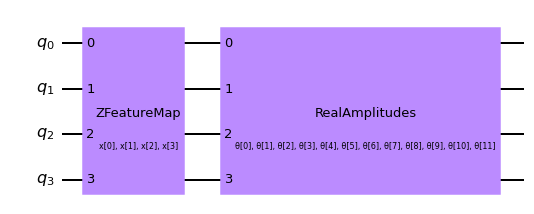

In [84]:
qc = QuantumCircuit(2**num_qubits)
qc.append(initial, range(2**num_qubits))
qc.append(ansatz, range(2**num_qubits))
qc.decompose().draw(output='mpl')

In [85]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2
output_shape = 2**(num_qubits-1)

In [86]:
# specify circuit QNN
qnn = CircuitQNN(qc, input_params=initial.parameters, weight_params=ansatz.parameters, output_shape=output_shape, interpret=parity, 
                  quantum_instance=qi_qasm)

In [87]:
initial.parameters, ansatz.parameters

(ParameterView([ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(x[2]), ParameterVectorElement(x[3])]),
 ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11])]))

In [88]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    print('Iteration is', len(objective_func_vals))
    print('Weights are', weights)
    print('Objective function value is', obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [89]:
circuit_classifier = NeuralNetworkClassifier(neural_network=qnn, callback=callback_graph,
                                             optimizer=COBYLA())

Iteration is 148
Weights are [ 2.32841946  2.07556925  0.67644425  0.80246584  1.63636175  1.51324012
  0.01582897 -0.28847281  0.00527391  0.03158548  1.56525198  1.63277134]
Objective function value is 87.9267578125


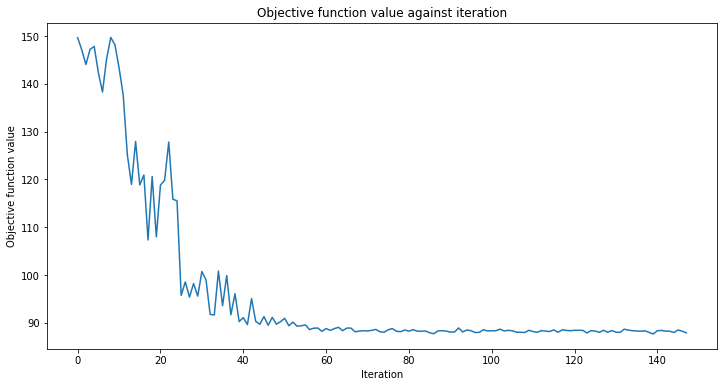

0.82

In [90]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
circuit_classifier.fit(X_train, y_train.flatten())

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
circuit_classifier.score(X_train, y_train.flatten())

In [91]:
circuit_classifier.score(X_test, y_test.flatten())

0.875

In [92]:
circuit_classifier.predict(X_test)

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1], dtype=int64)

In [93]:
y_test.flatten()

array([1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0.])

## Partial conclusion
We can observe that the amplitude encoding solution performs the best with a 100% score on the test dataset and 82% on the train dataset.

# Testing number of layers
We now want to discover what the optimal number of layers is for both encoding techniques in order to determine the best ansatz. For this, we use a number of layers in a range from 1 to 4 of the RealAmplitudes ansatz.

## Amplitude encoding

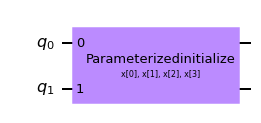

In [97]:
initial = RawFeatureVector(2**num_qubits)
initial.draw(output='mpl')

Iteration is 145
Weights are [ 0.95269004  0.08739606  1.7429998   1.72676307  0.12714973  2.9999766
  1.26489041  1.03656414  1.04360095 -0.04992397]
Objective function value is 55.2080078125


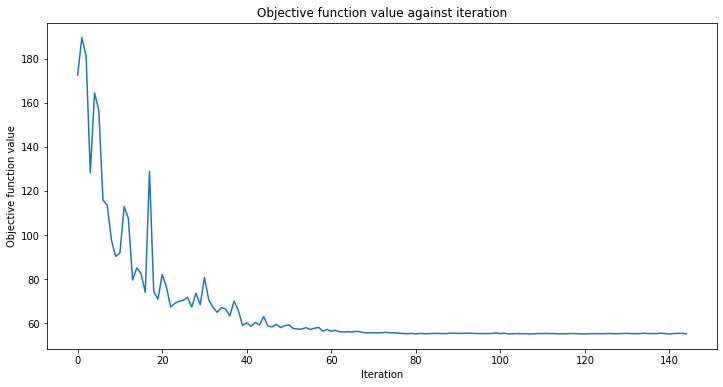

In [98]:
amplitude_train_score = []
amplitude_test_score = []
layers = list(range(1,5))
for i in layers:
    ansatz = RealAmplitudes(num_qubits, entanglement='full', reps=i)
    qc = QuantumCircuit(num_qubits)
    qc.append(initial, range(num_qubits))
    qc.append(ansatz, range(num_qubits))
    qc.decompose().draw(output='mpl')
    qnn = CircuitQNN(qc, input_params=initial.parameters, weight_params=ansatz.parameters, output_shape=output_shape, interpret=parity, 
                      quantum_instance=qi_qasm)
    circuit_classifier = NeuralNetworkClassifier(neural_network=qnn, callback=callback_graph,
                                                 optimizer=COBYLA())
    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)

    circuit_classifier.fit(X_train, y_train.flatten())

    plt.rcParams["figure.figsize"] = (6, 4)

    amplitude_train_score.append(circuit_classifier.score(X_train, y_train.flatten()))
    amplitude_test_score.append(circuit_classifier.score(X_test, y_test.flatten()))

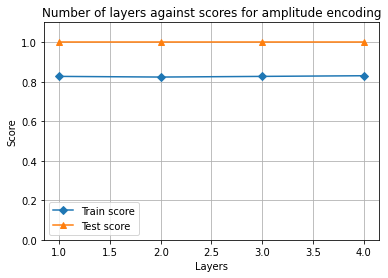

In [105]:
plt.title("Number of layers against scores for amplitude encoding")
plt.xlabel("Layers")
plt.ylabel("Score")
plt.plot(layers, amplitude_train_score, marker='D')
plt.plot(layers, amplitude_test_score, marker='^')
plt.ylim(0,1.1)
plt.legend(['Train score','Test score'])
plt.grid()
plt.show()

## Kernel encoding

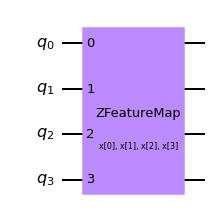

In [102]:
initial = ZFeatureMap(2**num_qubits)
initial.draw(output='mpl')

Iteration is 236
Weights are [ 1.43809279  0.63283338  0.63362418  0.75941233  0.05855976  0.1881616
  0.4702743  -0.11124617  0.47192389  1.75514975  1.51511344  1.44580495
  0.04850099  0.04573037  1.13315703  1.09588512  0.01319854  1.47068643
 -0.30241832  1.41535058]
Objective function value is 107.5986328125


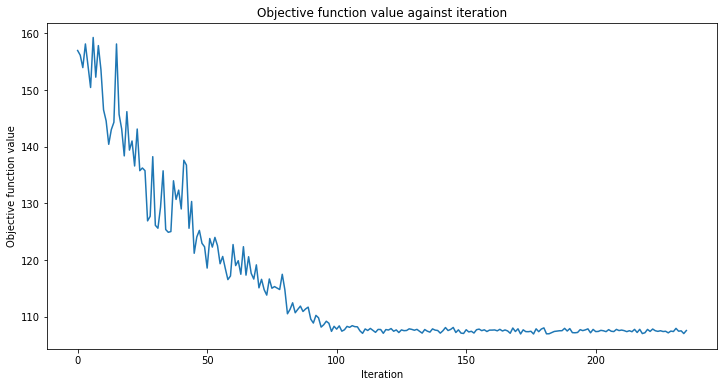

In [103]:
kernel_train_score = []
kernel_test_score = []
layers = list(range(1,5))
for i in layers:
    ansatz = RealAmplitudes(2**num_qubits, entanglement='full', reps=i)
    qc = QuantumCircuit(2**num_qubits)
    qc.append(initial, range(2**num_qubits))
    qc.append(ansatz, range(2**num_qubits))
    qc.decompose().draw(output='mpl')
    qnn = CircuitQNN(qc, input_params=initial.parameters, weight_params=ansatz.parameters, output_shape=output_shape, interpret=parity, 
                      quantum_instance=qi_qasm)
    circuit_classifier = NeuralNetworkClassifier(neural_network=qnn, callback=callback_graph,
                                                 optimizer=COBYLA())
    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)

    circuit_classifier.fit(X_train, y_train.flatten())

    plt.rcParams["figure.figsize"] = (6, 4)

    kernel_train_score.append(circuit_classifier.score(X_train, y_train.flatten()))
    kernel_test_score.append(circuit_classifier.score(X_test, y_test.flatten()))

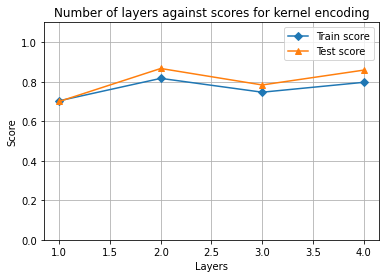

In [106]:
plt.title("Number of layers against scores for kernel encoding")
plt.xlabel("Layers")
plt.ylabel("Score")
plt.plot(layers, kernel_train_score, marker='D')
plt.plot(layers, kernel_test_score, marker='^')
plt.ylim(0,1.1)
plt.legend(['Train score','Test score'])
plt.grid()
plt.show()

## Conclusion
The conclusion for this task is that amplitude encoding is the best encoding technique and that, paired with the real amplitudes ansatz, test scores of 100% are obtained for the problem at hand, along with training scores of 82%. While kernel encoding is not the best encoding technique for this problem, two layers of the real amplitudes ansatz with kernel encoding are the best number of layers.